In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

plt.style.use("seaborn-v0_8")

## Curse of Dimensionality 
It refers to the problems associated with multivariate data analysis: for a given sample size, there is a maximum number of features above which the performance of our classifier will degrade rather than improve. In most cases, the extra information that is lost by discarding certain features is compensated by a more accurate mapping into the smaller dimensional space
- Solutions: 
    - Add a priori knowledge to weigh more some variables instead of others; 
    - Reduce dimensionality by using unsupervised algorithms

---


In [11]:
data = pd.read_csv("datasets/winequality-red.csv", sep=";")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]  # last column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Principal Component Analysis (PCA)
- https://www.youtube.com/watch?v=FD4DeN81ODY
- PCA it's an unsupervised method that uses an orthogonal transformation to convert a set of correlated variables into a set of uncorrelated variables.

- The primary goal of PCA is to reduce the dimensionality of a dataset while preserving the most important patterns or relationships between the variables, without any prior knowledge of the target variables. In fact, it does not consider the class labels of the samples ("class separability")

- PCA identifies a set of orthogonal axes (eigenvectors) that capture the maximum variance in the data. This process involves the following steps:
    1. **Standardization**: Each column (feature) of the dataset is standardized to have a mean of 0 and a standard deviation of 1. If one feature varies more than the others only because of their respective scales, PCA would determine that such feature dominates the direction of the principal components.
    2. **Covariance Matrix Calculation**: The covariance matrix of the standardized data is calculated.
    3. **Eigenvalues and Eigenvectors Calculation**: The eigenvalues and eigenvectors of the covariance matrix are calculated. The eigenvectors (which represent the directions in which the data vary the most) become the axes of the new space, while the eigenvalues (which indicate the amount of variance along each axis) determine the importance of each eigenvector. The eigenvectors are orthogonal to each other. A higher eigenvalue means that its eigenvector follows data that vary a lot.
    
        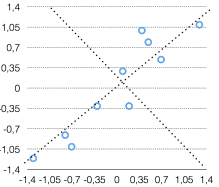 Here the best eigenvector is the one that follows the data points.
    
    4. **Principal Component Features Derivation**: The Principal Component features are derived by taking the dot product of the eigenvectors and the standardized columns. This projects the dataset into a new space with reduced dimensionality. Excluding the "non-significant" principal components may filter out the noise that is present in the data.

- The maximum number of PCs that can be calculated is min(n_samples, n_features)
- The number of PCs to keep is the one that preserves at least 95% of the total variance

In [12]:
# n_components is how many PCs to keep
pca = PCA(random_state=42, n_components="mle")
pca.fit(X_train)

X_train_t = pca.transform(X_train)
X_test_t = pca.transform(X_test)

# Percentage of variance explained by each of the selected components
# The sum needs to be at least 95%, otherwise too much information is lost
print(pca.explained_variance_ratio_)
print("Sum:", pca.explained_variance_ratio_.sum())

[9.48561286e-01 4.64263108e-02 2.51642763e-03 1.56686004e-03
 8.54121349e-04 3.59942769e-05 1.97718297e-05 9.54972714e-06
 8.45436759e-06 1.22342746e-06]
Sum: 0.9999999995231198


In [13]:
# Sort the explained variance ratios in descending order
ratios = np.flip(np.sort(pca.explained_variance_ratio_))

# Calculate the cumulative sum of the explained variance ratios
cum_sum = np.cumsum(ratios)

print(cum_sum)

# Find the index i of the first principal component where the cumulative sum exceeds 0.999
i = np.argmax(cum_sum > 0.999)
print(i)

# Keep the first i principal components and discard the rest
X_train_t = X_train_t[:, :i]
X_test_t = X_test_t[:, :i]

[0.94856129 0.9949876  0.99750402 0.99907088 0.99992501 0.999961
 0.99998077 0.99999032 0.99999878 1.        ]
3


In [14]:
# Classification with original data
clf = LogisticRegression(solver="liblinear", random_state=42, max_iter=300)
clf.fit(X_train, y_train)
print("Classification Accuracy: original:", clf.score(X_test, y_test))


# Classification with PCA data transformed
clf = LogisticRegression(solver="liblinear", random_state=42, max_iter=300)
clf.fit(X_train_t, y_train)
print("Classification Accuracy: transformed by PCA:", clf.score(X_test_t, y_test))

# Classification with PCA data transformed and selecting ONLY the most valuable attribute (the first)
col = 0
clf = LogisticRegression(solver="liblinear", random_state=42, max_iter=300)
X_train_t_head = X_train_t[:, col].reshape(-1, 1)
X_test_t_head = X_test_t[:, col].reshape(-1, 1)
clf.fit(X_train_t_head, y_train)
print(
    "Classification Accuracy: transformed by PCA, selecting only most valuable variable:",
    clf.score(X_test_t_head, y_test),
)

Classification Accuracy: original: 0.5625
Classification Accuracy: transformed by PCA: 0.49583333333333335
Classification Accuracy: transformed by PCA, selecting only most valuable variable: 0.4791666666666667


---
### Linear Discriminant Analysis (LDA)
- LDA is a supervised learning algorithm used to find a linear combination of features that best separates the classes in a dataset. LDA works by projecting the data onto a lower-dimensional space that maximizes the separation between the classes.

- It does this by finding a set of linear discriminants that maximize the ratio of between-class variance to within-class variance. In other words, it finds the directions in the feature space that best separates the different classes of data. 

- LDA assumes that the data has a Gaussian distribution and that the covariance matrices of the different classes are equal. It also assumes that the data is linearly separable, meaning that a linear decision boundary can accurately classify the different classes. In fact, often it's used to understand if a linear model can be used.

    1. **Compute the mean vectors**: For each class in the dataset, calculate the mean vector. Each element of the mean vector is the average of one feature for that class (therefore its width it's the number of dataset features)
    2. **Compute the scatter matrices**: Calculate the *within-class* ($S_W$) and *in-between-class* ($S_B$) scatter matrices ("intra-class" and "inter-class" matrices). The first captures the information about the spread of the data within each class. The second gathers information about how classes are spread between themselves.
    3. **Calculate the projection matrix**: Find a matrix, called the Projection matrix, that, multiplied by the original dataset, gives as a result a new space such that the class separability is maximized. It means maximizing the *in-between-class* scatter matrix while minimizing the *within-class* matrix. The columns of the Projection matrix are a subset of the $C-1$ largest (non-orthogonal) eigenvectors of the matrix $J = S_W^{-1} S_B$
    5. **Transform the dataset**: Project the original dataset onto this new subspace, taking the dot product of the Projection matrix and the standardized columns.

In [15]:
lda = LinearDiscriminantAnalysis(solver="eigen")
lda.fit(X_train, y_train)

X_train_t = lda.transform(X_train)
X_test_t = lda.transform(X_test)

In [16]:
# Classification with original data
clf = LogisticRegression(solver="liblinear", random_state=42, max_iter=200)
clf.fit(X_train, y_train)
print("Classification Accuracy: original:", clf.score(X_test, y_test))


# Classification with data transformed with LDA
clf = LogisticRegression(solver="liblinear", random_state=42, max_iter=200)
clf.fit(X_train_t, y_train)
print("Classification Accuracy: transformed by LDA:", clf.score(X_test_t, y_test))

# Classification with data transformed with LDA and selecting ONLY the most valuable attribute (the first)
col = 0
clf = LogisticRegression(solver="liblinear", random_state=42, max_iter=200)
X_train_t_head = X_train_t[:, col].reshape(-1, 1)
X_test_t_head = X_test_t[:, col].reshape(-1, 1)
clf.fit(X_train_t_head, y_train)
print(
    "Classification Accuracy: transformed by LDA, selecting only most valuable variable:",
    clf.score(X_test_t_head, y_test),
)

Classification Accuracy: original: 0.5625
Classification Accuracy: transformed by LDA: 0.5583333333333333
Classification Accuracy: transformed by LDA, selecting only most valuable variable: 0.40625


---
### t-distributed Stochastic Neighbor Embedding (t-SNE)
- It's a technique for dimensionality reduction that is particularly well-suited for the visualization of high-dimensional datasets
- More info:
• https://lvdmaaten.github.io/tsne/
• https://distill.pub/2016/misread-tsne

---
### SelectKBest
- A type of Univariate Feature Selection [(doc)](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)
- Selects the best features based on univariate statistical tests.
- These objects take as input a scoring function that returns univariate scores and p-values:
    - For regression: r_regression, f_regression, mutual_info_regression
    - For classification: chi2, f_classif, mutual_info_classif
- The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation. Note that the chi2 test should only be applied to non-negative features, such as frequencies.
- If you use sparse data (i.e. data represented as sparse matrices), chi2, mutual_info_regression, mutual_info_classif will deal with the data without making it dense

In [17]:
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [18]:
X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
X_new.shape

(150, 2)